In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform

import matplotlib.pyplot as plt
import seaborn as sns

/Users/jonwells/miniconda3/lib/python3.7/site-packages/seaborn/matrix.py:620: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


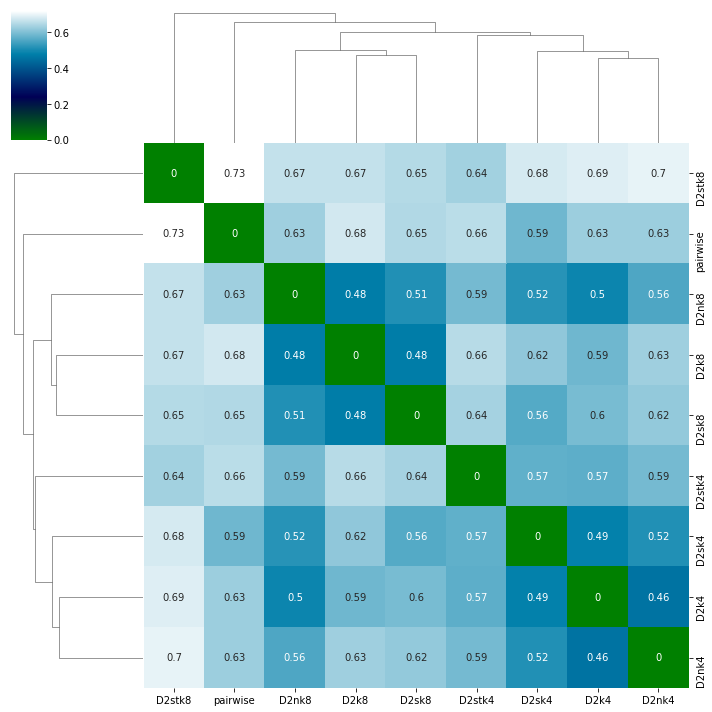

,value
variable,
D2nk8,4.459341
D2k4,4.522958
D2sk4,4.547844
D2sk8,4.714511
D2nk4,4.716789
D2k8,4.802664
D2stk4,4.922888
pairwise,5.201542
D2stk8,5.427971


In [2]:
rfdata = []
N = 2*(5709-3)
with open('../data/selection-analysis/D2_trees.nwk.rfdist') as infile:
    dims = (int(i) for i in infile.readline().split())
    for line in infile:
        rfdata.append([int(i)/N for i in line.split()[1:]])
rfdata = np.matrix(rfdata)

labels = ['D2k4', 'D2k8', 'D2nk4', 'D2nk8', 'D2sk4', 'D2sk8', 'D2stk4', 'D2stk8', 'pairwise']
df = pd.DataFrame(rfdata, columns=labels, index=labels)
g = sns.clustermap(df, cmap='ocean', annot=True)
plt.show()
df.reset_index().melt(id_vars='index').groupby('variable').sum().sort_values('value')

In [50]:
pairwise_df = pd.read_csv('~/Desktop/disttest/pairwise_needleman.txt', sep='\t', header=None).drop_duplicates()
pairwise_df.columns = ['p1', 'p2', 'pid']
pairwise_df['pid'] = 100 - pairwise_df['pid']
pairwise_df = pairwise_df.pivot('p1', 'p2', 'pid')
labels = list(pairwise_df.columns)
with open('/Users/jonwells/Desktop/disttest/names.txt') as infile:
    omit = [line.strip() for line in infile]

# It is much faster to perform these operations in a numpy array than a DataFrame.
pairwise_mat = pairwise_df.to_numpy()
for i in range(len(labels)):
    for j in range(len(labels)):
        if pairwise_mat[i][j] != pairwise_mat[j][i]:
            val=min(pairwise_mat[i][j], pairwise_mat[j][i])
            pairwise_mat[i][j] = val
            pairwise_mat[j][i] = val
            
pairwise_df = pd.DataFrame(data=pairwise_mat,
                           index=labels,
                           columns=labels).drop(omit).drop(omit, axis=1)
pairwise_mat = pairwise_df.to_numpy()

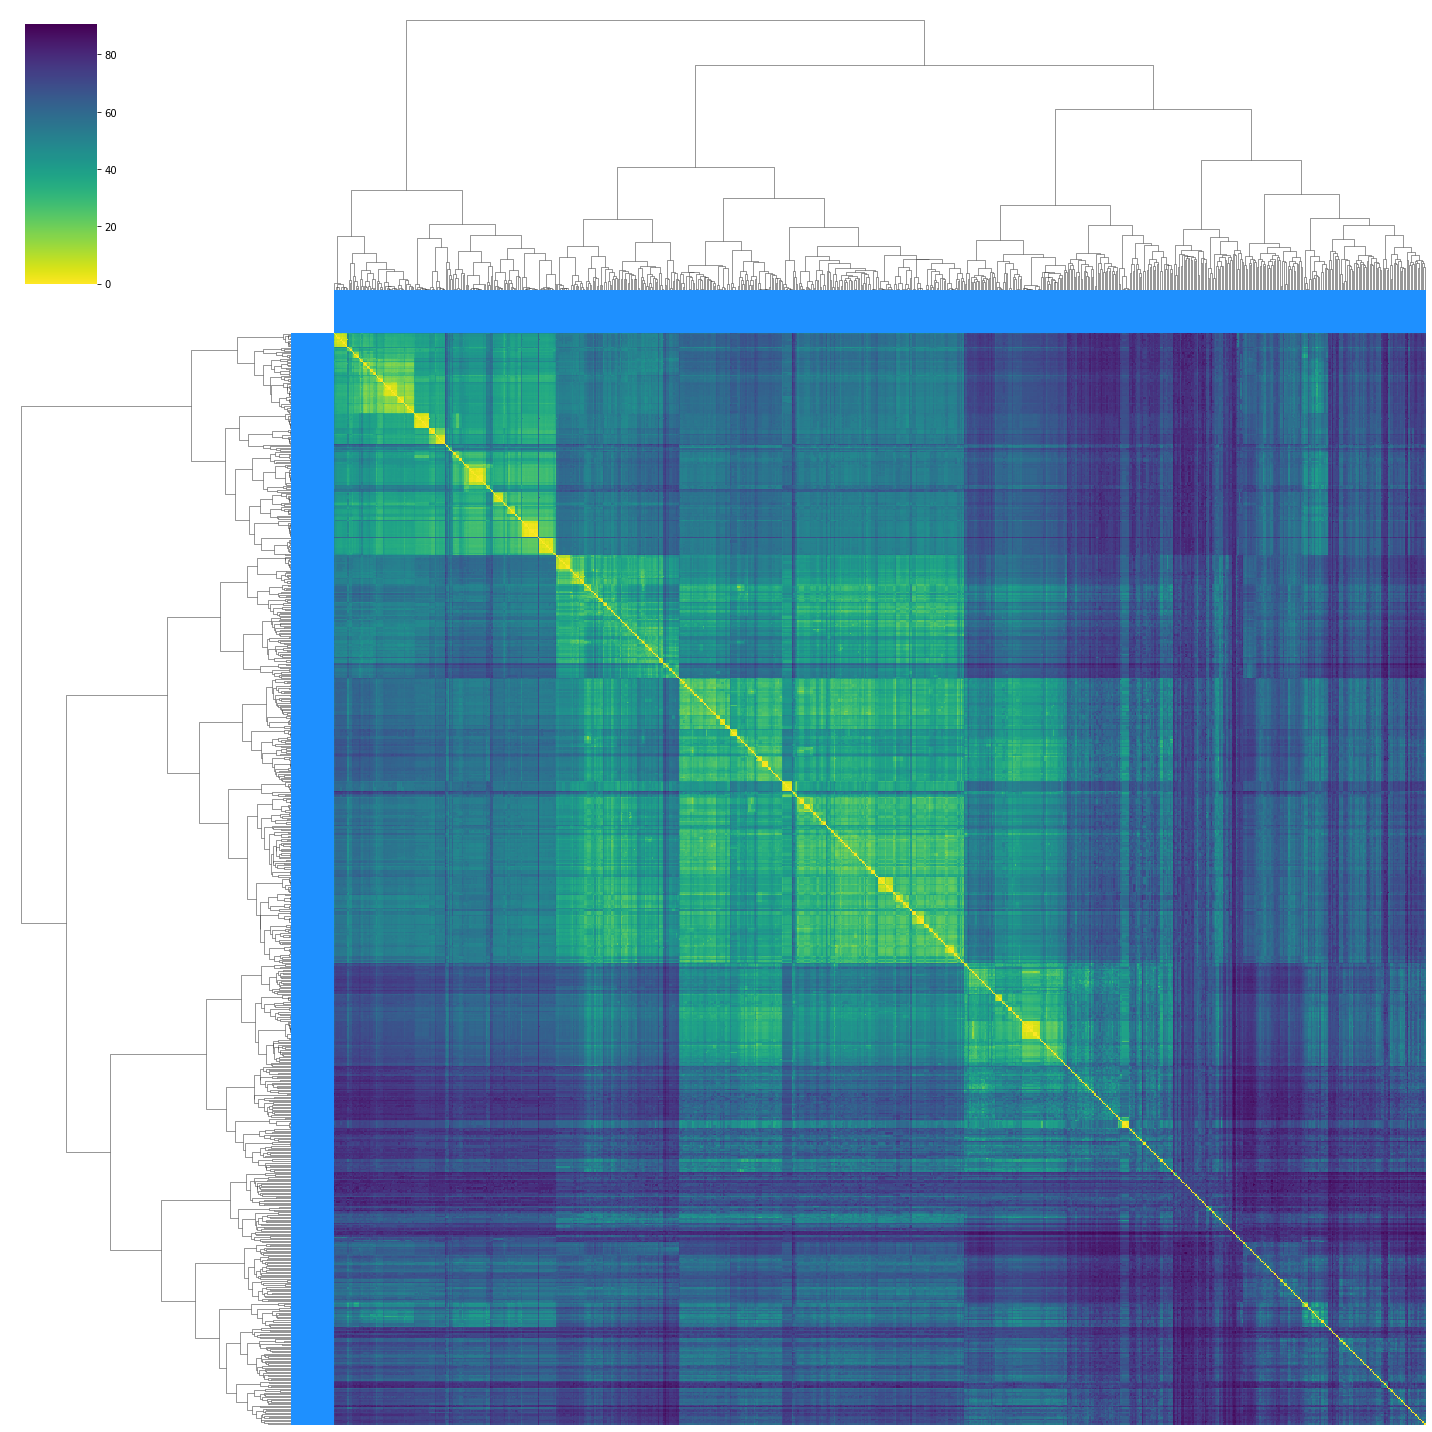

In [51]:
Z = linkage(squareform(pairwise_mat), method='ward')

clusters = sorted(zip(labels, fcluster(Z, 4, 'maxclust')), key=lambda x: x[1])
with open('../data/waterman_cluster_assignments.txt', 'w') as outfile:
    for c in clusters:
        outfile.write(f'lcl|{c[0]}\t{c[1]}\n')

colors = ['black' if i.startswith('4') 
          else 'orange' if i.startswith('Super_scaffold') 
          else 'dodgerblue' 
          for i in pairwise_df.columns]

g = sns.clustermap(pairwise_df, 
                   row_linkage=Z, 
                   col_linkage=Z, 
                   figsize=(20,20),
                   cmap='viridis_r', 
                   row_colors=colors, 
                   col_colors=colors,
                   xticklabels='',
                   yticklabels='')
plt.show()
g.savefig('../figs/expressed_ward_needleman.png')

Now, we would like to see the relationship between chromosomal location and sequence identity. We will restrict ourselves to chromosome 4, which is 78,093,715 bp long.

In [127]:
tss_df = pd.read_csv('/Users/jonwells/Desktop/disttest/denovo_start_codon.txt', sep='\t', header=None).sort_values([1])
tss_df = tss_df.loc[tss_df[1] == 'NC_007115.7']
tss_df = tss_df.loc[~tss_df[1].isin(omit)].reset_index()
# tss_df[0] = tss_df[0].apply(lambda x: x.strip('lcl|'))
# tss_df = tss_df.loc[tss_df[0].str.startswith('NC_007115.7')]  # Extract chr4 only
# tss_df = tss_df.loc[tss_df[0].str.startswith('NC_007126.7')]  # Extract chr15 only
tss = list(zip(tss_df[0], tss_df[2]))
tss = [i for i in tss if i[0] in list(pairwise_df.columns)]

data = []
chromstart = int(78093716*1/3)
# chromstart = 1
chromsize = 78093716  # chr4; chr15 is 7809371
window = 100000

for i in range(chromstart, chromsize, window):
    nexti = i + window
    row = []
    p1 = None
    for k in tss:
        if i <= k[1] < nexti:
            p1 = k[0]
            break
    for j in range(chromstart, chromsize, window):
        nextj = j + window
        p2 = None
        for k in tss:
            if j <= k[1] < nextj:
                p2 = k[0]
                break
        if p1 and p2:
            pairval = pairwise_df.loc[p1, p2]
            if pairval <= 100:
                row.append(pairval)
            else:
                row.append(100.0)
        else:
            row.append(100.0)                
    data.append(row)

data = np.asarray(data)
print(data)

[[100. 100. 100. ... 100. 100. 100.]
 [100. 100. 100. ... 100. 100. 100.]
 [100. 100. 100. ... 100. 100. 100.]
 ...
 [100. 100. 100. ... 100. 100. 100.]
 [100. 100. 100. ... 100. 100. 100.]
 [100. 100. 100. ... 100. 100.   0.]]


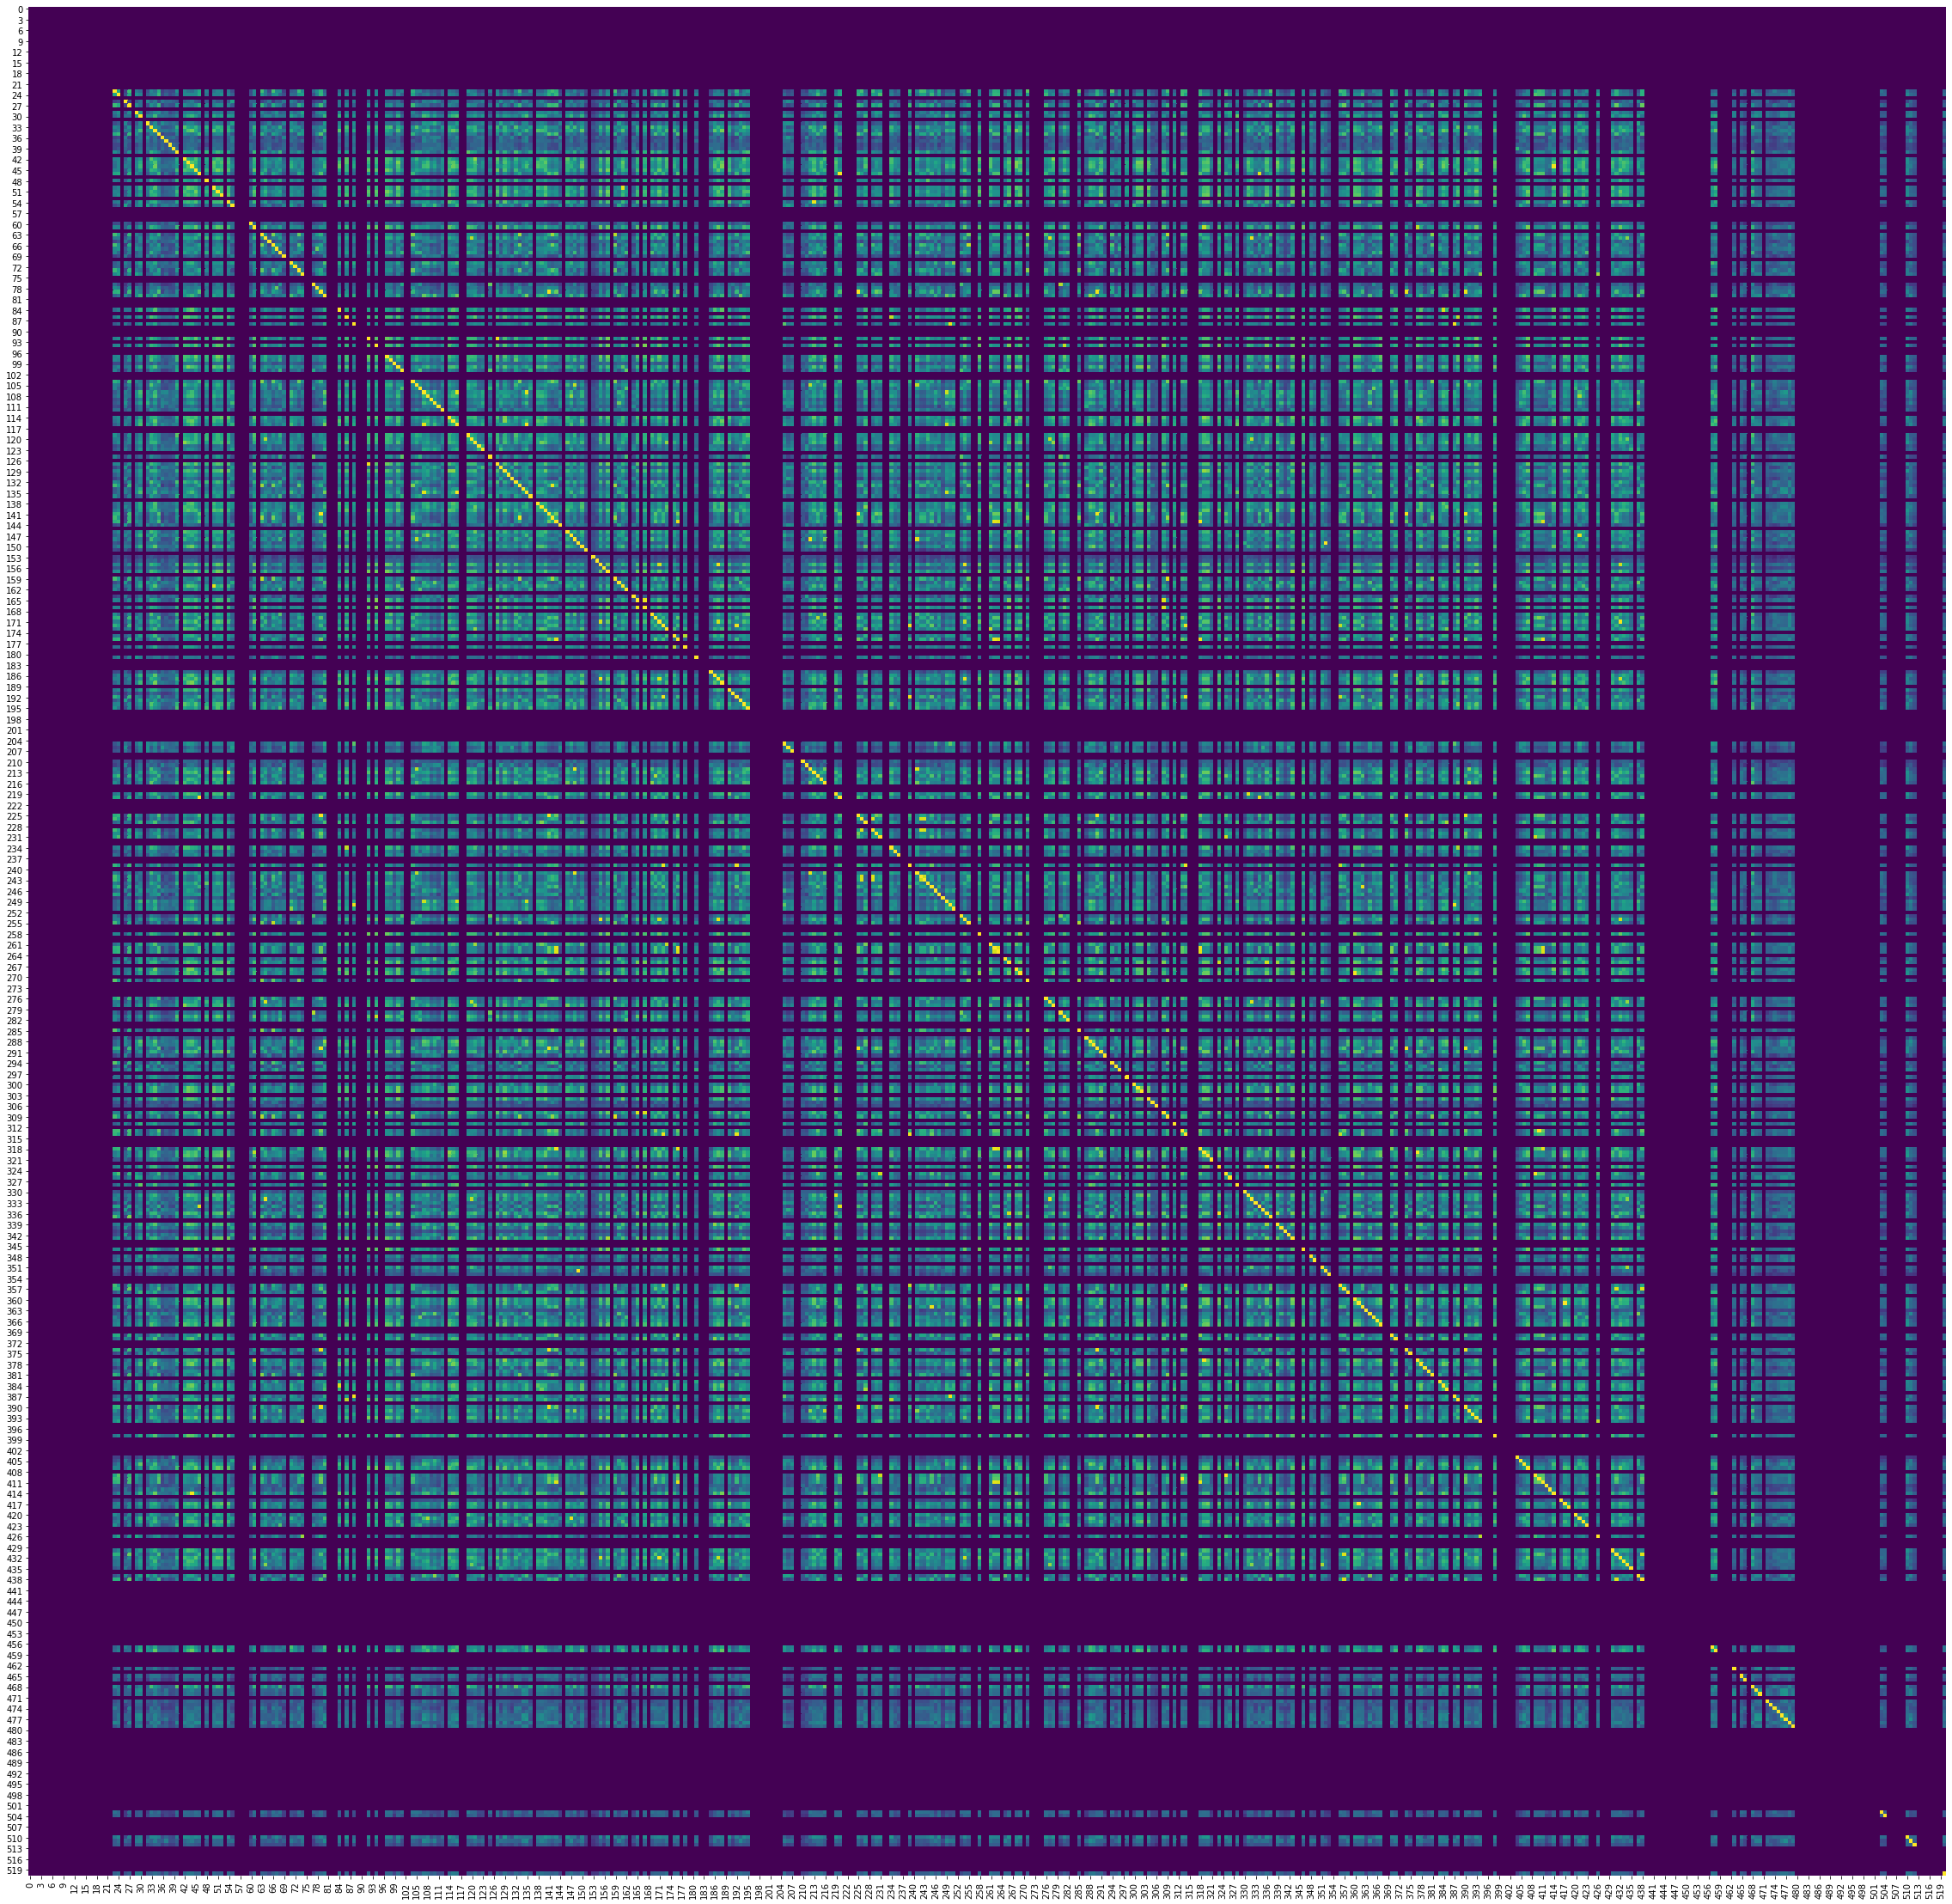

In [128]:
fig, ax = plt.subplots(figsize=(40, 40))
sns.heatmap(data,
            cmap='viridis_r',
            cbar=False)
plt.savefig('../figs/expressed_tss_heatmap.png')
plt.show()


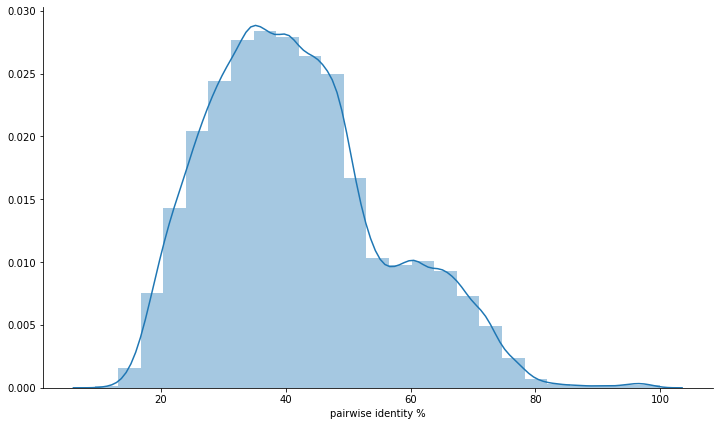

In [129]:
fig, ax = plt.subplots(figsize=(12, 7))
d = 100 - squareform(pairwise_df)
sns.distplot(d, bins=25)
ax.set_xlabel('pairwise identity %')
sns.despine()
plt.show()

In [131]:
# tss_df = tss_df.reset_index()
for_corr = []
for i, igene in tss_df.iterrows():
    for j, jgene in tss_df.iterrows():
        if j <= i:
            continue
        try:
            for_corr.append((abs(igene[2] - jgene[2]), pairwise_df.loc[igene[0], jgene[0]]))
        except:
            continue

(0.11237857339460686, 0.0)


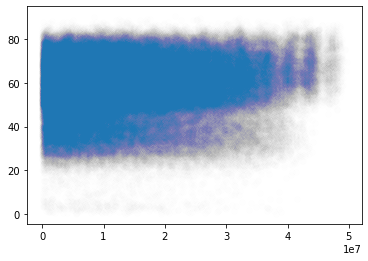

In [143]:
plt.scatter([i[0] for i in for_corr], [i[1] for i in for_corr], alpha=0.005)
print(stats.pearsonr([i[0] for i in for_corr], [i[1] for i in for_corr]))